In [1]:
import numpy as np
import os
import matplotlib
from matplotlib import pyplot as plt
import matplotlib.cm as cm
import pathlib
from statistics import median
from skimage import io
from skimage import img_as_ubyte
from skimage import data
from skimage import color
from skimage.util import view_as_blocks, view_as_windows
import imageio
import torch
from pixel_level_contrastive_learning import PixelCL
from torchvision import models
from tqdm import tqdm
from skimage import io, exposure, util, data, color
from torch.utils.data import Dataset, DataLoader
from torchinfo import summary
from tqdm import tqdm
from torch.nn import functional as F
from torch import nn
from torchvision import transforms
from PIL import Image
from skimage.measure import label
from skimage.segmentation import watershed, expand_labels
import torchvision
import warnings
warnings.filterwarnings('ignore')

# Path where original stacks are present
RAW_IMAGES_PATH = "/home/snamburi/Srinath/raw_train_images/"
RAW_MASKS_PATH = "/home/snamburi/Srinath/raw_train_masks/"

# Path where the final processed images and masks are present
IMAGES_PATH = '/home/snamburi/Srinath/data/images/'
ORIGINAL_MASKS_PATH = '/home/snamburi/Srinath/data/original_masks/'

ZEBRAFISH_IMAGES_PATH = '/home/snamburi/Srinath/zebrafish/images/'
ZEBRAFISH_PREDICTED_MASKS_PATH = '/home/snamburi/Srinath/zebrafish/predicted_masks/'

# Path where predicted masks are stored
PREDICTED_MASKS_PATH = '/home/snamburi/Srinath/data/predicted_masks/'

# Window shape, used to slice the input image into different patches
WINDOW_SHAPE = (384, 384)

# Split the data to train and test using test_percent
VALIDATION_PERCENT = 0.1
learning_rate = 1e-4

# Number of epochs to train SSL model and SSL+Segmentation model. We can train for different epochs if required
epochs_for_ssl = 10
epochs_for_downstream = 10
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# print(torch.cuda.is_available())
torch.cuda.set_device(0)

In [2]:
def merge_stacks(path):
    '''
    Given a directory having stacks, it'll do the following
        1. Divides each slice in each stack into patches (using view_as_windows) of window_shape
        2. Attaches all these patches as a giant stack (which is used by filtering function)
        
    Input: Directory where the individual stacks are present
    Output: A big stack where each slice is a patch of window_shape
    
    Note: Step size and Window Size in view_as_windows function might need to be changed based on given input data dimensions
    '''
    stacks_list = os.listdir(path)
    big_stack = []
    for file_path in pathlib.Path(path).iterdir():
        print(f"Reading: {file_path}")
        stack = imageio.mimread(file_path)
        np_stack = np.asarray(stack)
        for slice_idx in range(len(np_stack)):
            patches = view_as_windows(np_stack[slice_idx], WINDOW_SHAPE, step=(64, 64))
            for row in range(patches.shape[0]):
                for col in range(patches.shape[1]):
                    big_stack.append(patches[row][col])
    return big_stack

In [3]:
image_stack = merge_stacks(RAW_IMAGES_PATH)
mask_stack = merge_stacks(RAW_MASKS_PATH)
        
print(f"Total no of patches: {len(image_stack)}")
print(f"Shape of each patch: {mask_stack[0].shape}")
print(f"Total No of masks (verifying it's equal to no of patches): {len(image_stack)}")
print(f"Shape of each mask (verifying it's same as patch dims: {mask_stack[0].shape}")

Reading: /home/snamburi/Srinath/raw_train_images/t000.tif
Reading: /home/snamburi/Srinath/raw_train_images/t001.tif
Reading: /home/snamburi/Srinath/raw_train_images/t002.tif
Reading: /home/snamburi/Srinath/raw_train_images/t003.tif
Reading: /home/snamburi/Srinath/raw_train_images/t004.tif
Reading: /home/snamburi/Srinath/raw_train_masks/man_seg000.tif
Reading: /home/snamburi/Srinath/raw_train_masks/man_seg001.tif
Reading: /home/snamburi/Srinath/raw_train_masks/man_seg002.tif
Reading: /home/snamburi/Srinath/raw_train_masks/man_seg003.tif
Reading: /home/snamburi/Srinath/raw_train_masks/man_seg004.tif
Total no of patches: 3150
Shape of each patch: (384, 384)
Total No of masks (verifying it's equal to no of patches): 3150
Shape of each mask (verifying it's same as patch dims: (384, 384)


In [4]:
# Saving and Reading the same stack is optional, check with memory constraints
# Did to understand how the stack looks

# imageio.mimsave(f'{sample_path}stacked_img.tiff', image_stack)
# imageio.mimsave(f'{sample_seg_path}stacked_seg_img.tiff', mask_stack)

# image_stack = imageio.mimread(f'{sample_path}stacked_img.tiff', memtest='1024MB')
# mask_stack = imageio.mimread(f'{sample_seg_path}stacked_seg_img.tiff', memtest='1024MB')

In [5]:
def calculate_threshold(image_stack):
    '''
    Get the threshold for the entire stack. This is used to decide whether a 
    patch is useful as training data or not
    '''
    mean_dict = {}
    for slice_idx in range(len(image_stack)):
        mean_dict[slice_idx] = image_stack[slice_idx].mean()
    threshold = sum(mean_dict.values())/len(mean_dict.values())
    return threshold

In [6]:
threshold = calculate_threshold(image_stack)
threshold

29.353533905406028

In [7]:
def plot_histograms(image_stack):
    '''
    Plotting histograms. Just for analysis. Not used
    '''
    mean_dict = {}
    max_list, min_list = [], []
    filtered_ip_stack, filtered_op_stack = [], []
    for slice_idx in range(len(image_stack)):
        mean_dict[slice_idx] = image_stack[slice_idx].mean()
        max_list.append(image_stack[slice_idx].max())
        min_list.append(image_stack[slice_idx].min())
        
    print(f"Max of Mean values: {max(mean_dict.values())}")
    print(f"Max of max values: {max(max_list)}")
    print(f"Min of min values: {min(min_list)}")
    print(f"Total no of patches: {len(max_list)}")
    threshold = sum(mean_dict.values())/len(mean_dict.values())
    print(f"Mean of all patches (using this as threshold): {threshold}")
    print(f"Median of all patches: {median(mean_dict.values())}")

    plt.hist(max_list, density=False)
    plt.xlabel('Max Pixel intensities (8 bit)')
    plt.ylabel('No of images')
    plt.title('No of images vs max intensity')
    plt.show()

    plt.hist(min_list, density=False)
    plt.xlabel('Min Pixel intensities (8 bit)')
    plt.ylabel('No of images')
    plt.title('No of images vs min intensity')
    plt.show()

    plt.hist(mean_dict.values(), density=False)
    plt.xlabel('Mean Pixel intensities (8 bit)')
    plt.ylabel('No of images')
    plt.title('No of images vs mean intensity')
    plt.show()
    plt.savefig('Mean_not_scaled.png')

In [8]:
# Used only for analysis
# plot_histograms(image_stack)

In [9]:
def create_data(image_stack, mask_stack, threshold):
    '''
    Saving images and masks which have a mean > threshold.
    '''
    for patch_idx in range(len(image_stack)):
        image = image_stack[patch_idx]
        mask = mask_stack[patch_idx]
        if(image.mean() >= threshold):
            io.imsave(f"{IMAGES_PATH}/{patch_idx}.tiff", image)
            io.imsave(f"{ORIGINAL_MASKS_PATH}/{patch_idx}.tiff", mask)

In [ ]:
create_data(image_stack, mask_stack, threshold)

In [10]:
class SegmentationDataset(Dataset):
    '''
    Class for Dataloader
    
    init: Initialise the paths for image directory and mask directory
    len: Just to check how many images are present in directory
    getitem: Do transformations and return the image and mask (did normalization)
    (FUTURE WORK: CAN PUT ALL THE TRANSFORMATIONS INSIDE TRANSFORM AND TARGET_TRANSFORM)
    '''
    def __init__(self, img_dir, mask_dir, transform=None, target_transform=None):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.target_transform = target_transform
        self.img_list = os.listdir(img_dir)

    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_list[idx])
        mask_path = os.path.join(self.mask_dir, self.img_list[idx])

        file_name = img_path.split('/')[-1]
        file_name = file_name.split('.')[0]
        
        img = io.imread(img_path)
        img = img.astype(np.int64)
        img = torch.tensor(img)
        img = img.float()
        img.unsqueeze_(0)
        img = img.repeat(3,1,1)
        
        mask = io.imread(mask_path)
        # mask = mask.astype(np.int64)
        W, H = mask.shape
        if (np.max(mask) != np.min(mask)):
            mask = (mask - np.min(mask)) / (np.max(mask) - np.min(mask))
            mask[mask > 0] = 1
            mask[mask <= 0] = 0
        else:
            mask = np.zeros((W, H))
        mask = torch.tensor(mask)
        mask = mask.long()
        
        
        # if self.transform:
        #     img = self.transform(img)
        # if self.target_transform:
        #     mask = self.target_transform(mask)
            
        return (img, mask, file_name)


class Identity(torch.nn.Module):
    '''
    Used when attaching FCN header to Resnet backbone. It basically returns the input as output
    '''
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return x


In [11]:
segmentation_dataset = SegmentationDataset(IMAGES_PATH, ORIGINAL_MASKS_PATH)

total_samples = len(segmentation_dataset)
n_test = 100
n_val = int(total_samples * VALIDATION_PERCENT) - n_test
n_train = total_samples - n_val - n_test
print("Training and validation samples are {0} and {1}".format(n_train, n_val))

Training and validation samples are 1233 and 37


In [12]:
train_index, validation_index = [], []

# n_train_fcn_samples will be either 50, 100, 500 or total training data i.e n_train
n_train_fcn_samples = n_train

# n_train_ssl_samples will be either 50, 100, 500 or total training data i.e n_train 
# i.e train the backbone using SSL with varying data
n_train_ssl_samples = n_train

train_data, validation_data, test_data = torch.utils.data.random_split(segmentation_dataset, [n_train, n_val, n_test],
                                                     generator=torch.Generator().manual_seed(42))

train_data_subset, rest = torch.utils.data.random_split(train_data, [n_train_fcn_samples, len(train_data) - n_train_fcn_samples],
                                                     generator=torch.Generator().manual_seed(42))

ssl_data_subset, rest = torch.utils.data.random_split(segmentation_dataset, [n_train_ssl_samples, total_samples - n_train_ssl_samples],
                                                     generator=torch.Generator().manual_seed(42))

print("Training samples for SSL and FCN are {0} and {1}".format(len(ssl_data_subset), len(train_data_subset)))

# Loader for Self Supervised Learning - ssl_dataloader (we want to train SSL on entire dataset, 
# labelled and unlabeled ones to get some good embeddings)

ssl_dataloader = DataLoader(ssl_data_subset, batch_size=8, shuffle=True, num_workers=0, drop_last=True)

# Loaders for Downstream Tasks - Train dataloader used to update weights of downstream network
# Tes dataloader (which has labels) is used for accuracy, loss score analysis
training_dataloader = DataLoader(train_data_subset, batch_size=8, shuffle=True, num_workers=0, drop_last=True)
validation_dataloader = DataLoader(validation_data, batch_size=8, shuffle=False, num_workers=0, drop_last=True)
test_dataloader = DataLoader(test_data, batch_size=8, shuffle=True, num_workers=0, drop_last=True)
    
# Check how many batches of data we have (it will be appx x*batch_size = total_data)
print("No of batches for SSL loader, FCN train loader are: {0} and {1}".format(len(ssl_dataloader), len(training_dataloader)))

Training samples for SSL and FCN are 1233 and 1233
No of batches for SSL loader, FCN train loader are: 154 and 154


In [13]:
# Though manual seed is given, sometimes the dataset is randomly shuffled

for _, _, j in test_dataloader:
    if '269' in j:
        print("Our sample image is present in test set")

Our sample image is present in test set


In [14]:
def plot_loss_vs_epochs(epoch_train_loss, epoch_test_loss, fig_title):
    '''
    Plotting train and test error vs no of epochs
    '''
    epoch = np.arange(0, len(epoch_train_loss))
    plt.plot(epoch, epoch_train_loss, label='Training Loss')
    plt.plot(epoch, epoch_test_loss, label='Validation Loss')
    plt.title(fig_title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend(loc='upper right')
    plt.show()

In [15]:
def plot_loss_vs_epochs_ssl(epoch_loss, fig_title):
    '''
    Plotting train error vs no of epochs for SSL task. 
    '''
    epoch = np.arange(0, len(epoch_loss))
    plt.plot(epoch, epoch_loss, label='Training Loss')
    plt.title(fig_title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend(loc='upper right')
    plt.show()

In [395]:
resnet = models.resnet50(pretrained=True)

learner = PixelCL(
    resnet,
    image_size = 384,
    hidden_layer_pixel = 'layer4',  # leads to output of 8x8 feature map for pixel-level learning
    hidden_layer_instance = -2,     # leads to output for instance-level learning
    projection_size = 256,          # size of projection output, 256 was used in the paper
    projection_hidden_size = 2048,  # size of projection hidden dimension, paper used 2048
    moving_average_decay = 0.99,    # exponential moving average decay of target encoder
    ppm_num_layers = 1,             # number of layers for transform function in the pixel propagation module, 1 was optimal
    ppm_gamma = 2,                  # sharpness of the similarity in the pixel propagation module, already at optimal value of 2
    distance_thres = 0.7,           # ideal value is 0.7, as indicated in the paper, which makes the assumption of each feature map's pixel diagonal distance to be 1 (still unclear)
    similarity_temperature = 0.3,   # temperature for the cosine similarity for the pixel contrastive loss
    alpha = 1.,                     # weight of the pixel propagation loss (pixpro) vs pixel CL loss
    use_pixpro = True,              # do pixel pro instead of pixel contrast loss, defaults to pixpro, since it is the best one
    cutout_ratio_range = (0.6, 0.8) # a random ratio is selected from this range for the random cutout
).to(device)

opt = torch.optim.Adam(learner.parameters(), lr=learning_rate)

epoch_loss = []
min_loss = 10000
no_of_batches = len(ssl_dataloader)
print("No of batches the backbone is trained is {0}".format(no_of_batches))
for _ in tqdm(range(epochs_for_ssl)):
    total_loss = 0
    for batch, _, _ in ssl_dataloader:
        images = batch.to(device)
        loss = learner(images) # if positive pixel pairs is equal to zero, the loss is equal to the instance level loss
        opt.zero_grad()
        loss.backward()
        total_loss += loss.item()
        opt.step()
        learner.update_moving_average() # update moving average of target encoder
    
    total_loss/=no_of_batches
    epoch_loss.append(total_loss)
    if total_loss < min_loss:
        min_loss = total_loss
        torch.save(resnet, 'improved_resnet_ssl_10epochs_500samples_best.pt')
        print(total_loss)

No of batches the backbone is trained is 125


 10%|████▍                                       | 1/10 [00:36<05:30, 36.71s/it]

2.0729233837127685


100%|███████████████████████████████████████████| 10/10 [05:55<00:00, 35.56s/it]


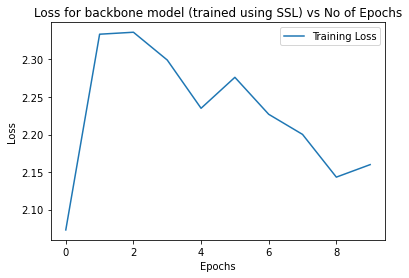

In [396]:
plot_loss_vs_epochs_ssl(epoch_loss, 'Loss for backbone model (trained using SSL) vs No of Epochs')

In [4]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


# Code for CIFAR 10 dataset (only the next 2 cells)

In [14]:
import torch
from pixel_level_contrastive_learning import PixelCL
from torchvision import models
from tqdm import tqdm

resnet = models.resnet50(pretrained=True)

learner = PixelCL(
    resnet,
    image_size = 256,
    hidden_layer_pixel = 'layer4',  # leads to output of 8x8 feature map for pixel-level learning
    hidden_layer_instance = -2,     # leads to output for instance-level learning
    projection_size = 256,          # size of projection output, 256 was used in the paper
    projection_hidden_size = 2048,  # size of projection hidden dimension, paper used 2048
    moving_average_decay = 0.99,    # exponential moving average decay of target encoder
    ppm_num_layers = 1,             # number of layers for transform function in the pixel propagation module, 1 was optimal
    ppm_gamma = 2,                  # sharpness of the similarity in the pixel propagation module, already at optimal value of 2
    distance_thres = 0.7,           # ideal value is 0.7, as indicated in the paper, which makes the assumption of each feature map's pixel diagonal distance to be 1 (still unclear)
    similarity_temperature = 0.3,   # temperature for the cosine similarity for the pixel contrastive loss
    alpha = 1.,                      # weight of the pixel propagation loss (pixpro) vs pixel CL loss
    use_pixpro = True,               # do pixel pro instead of pixel contrast loss, defaults to pixpro, since it is the best one
    cutout_ratio_range = (0.6, 0.8)  # a random ratio is selected from this range for the random cutout
).cuda()

opt = torch.optim.Adam(learner.parameters(), lr=1e-4)

def sample_batch_images():
    return torch.randn(10, 3, 256, 256).cuda()

epoch_loss = []
no_of_batches = len(trainloader)
for _ in tqdm(range(10)):
    total_loss = 0
    for i, batch in enumerate(trainloader, 0):
        images, labels = batch
        loss = learner(images.to(device)) # if positive pixel pairs is equal to zero, the loss is equal to the instance level loss

        opt.zero_grad()
        loss.backward()
        total_loss += loss.item()
        opt.step()
        learner.update_moving_average() # update moving average of target encoder
        
    total_loss/=no_of_batches
    epoch_loss.append(total_loss)
    print(total_loss)

    
# after much training, save the improved model for testing on downstream task
torch.save(resnet, 'improved-resnet.pt')


 10%|████                                    | 1/10 [30:10<4:31:34, 1810.48s/it]

1.145626448674202


 20%|███████▌                              | 2/10 [1:00:07<4:00:19, 1802.41s/it]

0.8277874185228348


 30%|███████████▍                          | 3/10 [1:30:03<3:29:57, 1799.65s/it]

-0.21922843431711198


 40%|███████████████▏                      | 4/10 [1:59:59<2:59:49, 1798.24s/it]

-0.05911596315860748


 50%|███████████████████                   | 5/10 [2:29:55<2:29:46, 1797.31s/it]

-0.3551084323740005


 60%|██████████████████████▊               | 6/10 [2:59:53<1:59:49, 1797.48s/it]

-0.4742796366620064


 70%|██████████████████████████▌           | 7/10 [3:29:47<1:29:49, 1796.34s/it]

-0.6105019554805755


 80%|████████████████████████████████        | 8/10 [3:59:43<59:52, 1796.44s/it]

-0.5781331202030182


 90%|████████████████████████████████████    | 9/10 [4:29:40<29:56, 1796.41s/it]

-0.7421011624693871


100%|███████████████████████████████████████| 10/10 [4:59:35<00:00, 1797.54s/it]

-0.8324759884595871


NameError: name 'plot_loss_vs_epochs_ssl' is not defined

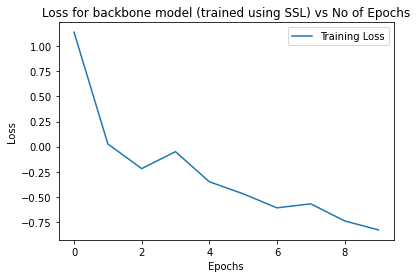

In [21]:
plot_loss_vs_epochs_ssl(epoch_loss, 'Loss for backbone model (trained using SSL) vs No of Epochs')

In [490]:
random_weights = models.resnet50(pretrained=False)
torch.save(random_weights, 'backbone_random_init_imagenet.pt')

In [21]:
def add_fcn_to_backbone(ssl_trained, backbone_trainable, random_init):
    '''
    Adding FCN Segmentation head to Resnet Backbone
    
    1. Loading the self supervised trained model
    2. Declaring the required_grad for all the layers as False (as we don't want to update these weights)
    3. Take the FCN_Head and change the last layer by matching the dimensions. 
        ConvTranspose2D is applied to increase the height and width
    4. Identity is applied to fc. Internally, it's flattening the dimensions (CHECK WHETHER THIS IMPLEMENTATION IS CORRECT)
    
    '''
    
    print("SSL Trained, backbone trainable and random init is set to {0}, {1}, {2}".format(ssl_trained, backbone_trainable, random_init))
    
    if ssl_trained:
        improved_resnet = torch.load('improved-resnet.pt')
        print('In SSL model')
        for param in improved_resnet.parameters():
            param.requires_grad = backbone_trainable
    else:
        if random_init:
            print('In random init')
            improved_resnet = torch.load('backbone_random_init_imagenet.pt')
            for param in improved_resnet.parameters():
                param.requires_grad = backbone_trainable
        else:
            improved_resnet = models.resnet50(pretrained=True)
            print('In Imagenet pretrained model')
            for param in improved_resnet.parameters():
                param.requires_grad = backbone_trainable
    
    # Pretrained = False given i.e not the optimal weights
    fcn_model = torch.hub.load('pytorch/vision:v0.10.0', 'fcn_resnet50', pretrained=True)
    
    # Method 1 - Doing one Transpose2D here and directly bilinear interpolating to original size
    # 12x12 --> 96x96 (By Transpose2D) and 96x96 --> 384x384 by bilinear interpolation
    # fcn_model.classifier[4] = torch.nn.ConvTranspose2d(512, 2, stride = (8,8), kernel_size = (8,8))
    
    # Method 2 - Doing a layers of Transpose2D to learn more parameters
    # 12x12 --> 48x48 --> 96x96 (By Transpose2D) and 96x96 --> 384x384 by bilinear interpolation
    fcn_model.classifier[4] = torch.nn.ConvTranspose2d(512, 256, stride = (4,4), kernel_size = (4,4))
    fcn_model.classifier = nn.Sequential(
        fcn_model.classifier,
        torch.nn.ConvTranspose2d(256, 2, stride = (2,2), kernel_size = (2,2))
    )
    # fcn_model.classifier[5] = torch.nn.ConvTranspose2d(256, 2, stride = (8,8), kernel_size = (8,8))
    improved_resnet.avgpool = fcn_model.classifier
    improved_resnet.fc = Identity()
    improved_resnet.to(device)
    
    return improved_resnet

In [22]:
'''
ssl_trained = True --> backbone is trained with SSL 
ssl_trained = False --> Resnet backbone is taken (and attached to FCN head for FSL)

backbone_trainable = True --> backbone weights are not frozen i.e tunable for downstream training
backbone_trainable = False --> backbone weights are frozen for downstream training
'''

improved_resnet = add_fcn_to_backbone(ssl_trained=True, backbone_trainable=False, random_init=False)

improved_resnet_summary = summary(improved_resnet, (16,3,384,384))
print(improved_resnet_summary)

SSL Trained, backbone trainable and random init is set to True, False, False
In SSL model


Using cache found in /home/snamburi/.cache/torch/hub/pytorch_vision_v0.10.0


Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   --                        --
├─Conv2d: 1-1                            [16, 64, 192, 192]        (9,408)
├─BatchNorm2d: 1-2                       [16, 64, 192, 192]        (128)
├─ReLU: 1-3                              [16, 64, 192, 192]        --
├─MaxPool2d: 1-4                         [16, 64, 96, 96]          --
├─Sequential: 1-5                        [16, 256, 96, 96]         --
│    └─Bottleneck: 2-1                   [16, 256, 96, 96]         --
│    │    └─Conv2d: 3-1                  [16, 64, 96, 96]          (4,096)
│    │    └─BatchNorm2d: 3-2             [16, 64, 96, 96]          (128)
│    │    └─ReLU: 3-3                    [16, 64, 96, 96]          --
│    │    └─Conv2d: 3-4                  [16, 64, 96, 96]          (36,864)
│    │    └─BatchNorm2d: 3-5             [16, 64, 96, 96]          (128)
│    │    └─ReLU: 3-6                    [16, 64, 96, 96]   

In [23]:
# Initialise CrossEntropyLoss and Adam Optimizer
loss_fn = nn.CrossEntropyLoss()
opt = torch.optim.Adam(improved_resnet.parameters(), lr=learning_rate)

In [24]:
for name, param in improved_resnet.named_parameters():
    print(param.data)

tensor([[[[ 1.2985e-02,  1.6427e-02, -1.3614e-02,  ..., -4.0696e-02,
           -4.2619e-02, -7.0125e-02],
          [ 3.9106e-03,  8.1229e-03,  1.6977e-02,  ...,  2.6617e-03,
           -1.9249e-02, -3.6769e-02],
          [ 2.1964e-02,  2.5661e-02,  1.8112e-02,  ...,  1.0307e-01,
            6.3538e-02,  5.3346e-02],
          ...,
          [-4.1486e-03,  2.8728e-02, -8.8227e-03,  ..., -1.2707e-01,
           -7.6282e-02,  8.7976e-03],
          [ 3.6049e-04,  4.8146e-02,  6.2469e-02,  ...,  2.3514e-02,
           -3.3730e-02, -1.5800e-02],
          [-8.3052e-02, -3.2039e-02, -1.7205e-02,  ...,  3.4736e-02,
            2.2642e-02,  1.9092e-03]],

         [[-1.9155e-02,  1.3133e-02,  2.5540e-02,  ...,  5.3815e-02,
            4.4352e-02, -8.9596e-03],
          [-8.1853e-03,  2.1197e-02,  7.0041e-02,  ...,  1.6002e-01,
            1.4763e-01,  1.2163e-01],
          [-4.6623e-02, -7.3972e-02, -8.7626e-02,  ...,  1.2134e-01,
            1.6789e-01,  1.7748e-01],
          ...,
     

tensor([ 2.5852e-01,  1.0744e-01,  1.7070e-03,  1.0193e-01,  1.5401e-01,
         2.2900e-06,  1.2145e-01,  2.6188e-01,  1.7379e-01,  3.1530e-02,
         8.3991e-02,  2.2161e-01,  1.9344e-01,  2.3377e-01, -2.7017e-06,
         1.1530e-01,  7.3852e-02,  1.3041e-01,  7.5411e-02,  1.6983e-01,
         8.4938e-02,  1.9763e-01,  1.7032e-01,  3.6475e-07,  2.4180e-01,
         1.0134e-01,  1.0449e-01,  1.0230e-01, -4.4109e-06,  5.4688e-02,
         1.8938e-01,  1.6123e-01,  1.0475e-01,  1.7089e-01,  2.1830e-01,
         1.4497e-01,  2.2450e-01,  1.5508e-01, -7.3290e-04,  1.4106e-01,
         9.8810e-02,  3.3815e-02,  8.7610e-02,  2.4752e-01,  6.6278e-02,
         8.1094e-02,  2.4402e-01,  1.3932e-01,  3.6825e-02,  1.1629e-01,
         1.3989e-01,  2.2358e-04,  2.7983e-02,  2.2041e-01,  3.1816e-01,
         3.9620e-02,  1.3517e-01,  7.7408e-02,  1.3719e-01,  8.4435e-07,
         1.4558e-01,  1.4126e-01,  5.9351e-02,  2.3573e-01,  2.7656e-02,
         9.7466e-02,  2.7181e-01,  6.9817e-02,  2.8

tensor([0.1262, 0.1125, 0.1142, 0.1085, 0.1374, 0.1192, 0.1562, 0.1667, 0.1561,
        0.1012, 0.1599, 0.1576, 0.1527, 0.1514, 0.1257, 0.1575, 0.2308, 0.1441,
        0.1692, 0.1401, 0.1486, 0.1807, 0.1404, 0.1415, 0.1346, 0.1400, 0.0998,
        0.1211, 0.1892, 0.1158, 0.1213, 0.1737, 0.1300, 0.1283, 0.1858, 0.1506,
        0.1472, 0.1584, 0.1707, 0.1802, 0.1736, 0.1852, 0.1250, 0.1848, 0.1750,
        0.1619, 0.1485, 0.1292, 0.1399, 0.1499, 0.1504, 0.1716, 0.1582, 0.1323,
        0.1384, 0.1673, 0.1958, 0.1642, 0.1498, 0.1347, 0.2229, 0.2098, 0.1856,
        0.1218, 0.1350, 0.1675, 0.1232, 0.1553, 0.1202, 0.1656, 0.1327, 0.1390,
        0.1722, 0.1578, 0.1436, 0.1400, 0.1953, 0.1473, 0.1818, 0.1987, 0.1630,
        0.1381, 0.2514, 0.1648, 0.1872, 0.1911, 0.1541, 0.1602, 0.1335, 0.1550,
        0.2287, 0.1637, 0.1483, 0.1593, 0.1960, 0.1823, 0.0998, 0.1756, 0.1751,
        0.1970, 0.1376, 0.1345, 0.1499, 0.2304, 0.1272, 0.1140, 0.1405, 0.1946,
        0.2255, 0.1322, 0.1721, 0.2245, 

tensor([[[[ 1.7175e-03]],

         [[ 9.2832e-03]],

         [[ 2.1953e-03]],

         ...,

         [[ 2.3139e-03]],

         [[ 1.2395e-03]],

         [[ 6.4512e-03]]],


        [[[ 1.2833e-02]],

         [[ 1.1299e-02]],

         [[ 5.7618e-02]],

         ...,

         [[-2.6617e-02]],

         [[-4.0678e-06]],

         [[ 8.2438e-03]]],


        [[[-4.5350e-02]],

         [[-2.1933e-03]],

         [[-2.4122e-02]],

         ...,

         [[-2.2582e-03]],

         [[ 1.1662e-02]],

         [[-3.8904e-02]]],


        ...,


        [[[-3.1221e-02]],

         [[ 7.5358e-03]],

         [[-9.8770e-03]],

         ...,

         [[ 3.5050e-02]],

         [[ 1.2624e-02]],

         [[-5.9086e-04]]],


        [[[-1.0811e-02]],

         [[-3.1632e-03]],

         [[ 2.9801e-03]],

         ...,

         [[ 1.1514e-02]],

         [[-5.2314e-03]],

         [[-2.0405e-02]]],


        [[[ 1.8919e-02]],

         [[-9.7900e-03]],

         [[ 2.4876e-04]],

         

tensor([0.4304, 0.4238, 0.4602, 0.4853, 0.4632, 0.4310, 0.4335, 0.4434, 0.4676,
        0.4798, 0.4371, 0.4312, 0.4274, 0.4248, 0.4744, 0.4293, 0.4320, 0.4266,
        0.4584, 0.4387, 0.4753, 0.4612, 0.4262, 0.4317, 0.4807, 0.4541, 0.4831,
        0.4339, 0.4351, 0.4637, 0.4542, 0.4708, 0.4373, 0.4567, 0.4261, 0.4299,
        0.4409, 0.4671, 0.4434, 0.4470, 0.4403, 0.4291, 0.4313, 0.4285, 0.4922,
        0.4617, 0.4211, 0.4525, 0.4507, 0.4381, 0.4528, 0.5044, 0.4549, 0.4639,
        0.4436, 0.4262, 0.4404, 0.4469, 0.4652, 0.4390, 0.4387, 0.4639, 0.4341,
        0.4401, 0.4426, 0.4688, 0.4543, 0.4364, 0.4491, 0.4316, 0.4189, 0.4378,
        0.4599, 0.4775, 0.4392, 0.4489, 0.4770, 0.4429, 0.4516, 0.4231, 0.4705,
        0.4855, 0.4511, 0.4781, 0.4200, 0.4595, 0.4176, 0.4227, 0.4366, 0.4336,
        0.4554, 0.4600, 0.4437, 0.4480, 0.4228, 0.4686, 0.4229, 0.4231, 0.4740,
        0.4724, 0.4481, 0.4599, 0.4632, 0.4347, 0.4684, 0.4524, 0.4479, 0.4651,
        0.4805, 0.4355, 0.4218, 0.4503, 

In [25]:
for name, param in improved_resnet.named_parameters():
    if param.requires_grad:
        print(name, param.data)

avgpool.0.0.weight tensor([[[[-1.7240e-03, -2.2570e-03, -3.2083e-03],
          [ 8.6283e-05, -6.0937e-03, -6.5595e-04],
          [-1.5284e-03, -5.2820e-03, -5.2351e-03]],

         [[-2.1641e-04,  9.6548e-04,  1.0510e-03],
          [-6.0216e-04,  1.8155e-04, -2.6645e-03],
          [ 2.4479e-04, -9.5545e-04,  2.8675e-05]],

         [[ 3.6089e-03,  2.7630e-03, -1.8777e-03],
          [ 3.5924e-03, -3.0409e-03, -2.3836e-04],
          [ 3.7118e-03, -9.2095e-04,  4.1914e-04]],

         ...,

         [[-2.1160e-04,  7.6872e-04,  6.9783e-04],
          [-1.7285e-03, -2.5159e-03,  2.7322e-03],
          [ 1.5834e-03, -1.0652e-03, -1.4586e-03]],

         [[-1.2479e-03, -4.4418e-04, -8.9228e-04],
          [-2.7323e-03, -3.2652e-03, -3.1604e-03],
          [-3.5589e-03, -1.4721e-03,  7.7104e-06]],

         [[-1.4844e-03, -9.0824e-04,  1.6852e-04],
          [-4.9857e-03, -2.6321e-03,  8.9388e-04],
          [ 1.7444e-04, -6.3173e-04, -3.3059e-03]]],


        [[[ 4.7575e-04, -1.7519e-0

In [26]:
# Checking what all layers has required_grad as True. 
for name, param in improved_resnet.named_parameters():
    if param.requires_grad:
        print(name, param.shape)

avgpool.0.0.weight torch.Size([512, 2048, 3, 3])
avgpool.0.1.weight torch.Size([512])
avgpool.0.1.bias torch.Size([512])
avgpool.0.4.weight torch.Size([512, 256, 4, 4])
avgpool.0.4.bias torch.Size([256])
avgpool.1.weight torch.Size([256, 2, 2, 2])
avgpool.1.bias torch.Size([2])


In [27]:
def bilinear_interpolation(predicted_mask, original_image):
    '''
    Given a predicted mask, reshape it and do bilinear transformation to match the shape of original mask
    
    Input: Predicted Mask (which is flattened)
    Steps:
        1. Reshaping it to (batch_size, 2, 96, 96) (NOTE: THIS 96 is currently hardcoded, need to change in future)
        2. Permute i.e change (B, C, H, W) to (C, B, H, W)
        3. Interpolate module in torch utilis converts this to desired shape
        4. Getting the argmax(0) of the predicted mask. 
        Refer to: https://colab.research.google.com/github/pytorch/pytorch.github.io/blob/master/assets/hub/pytorch_vision_deeplabv3_resnet101.ipynb
        
    Output: Predicted mask (converted to float, else loss is not computing) with same shape as original mask
    '''
    predicted_mask = predicted_mask.reshape(predicted_mask.shape[0], 2, 96, 96)
    # print(f"Predicted Mask reshaped to: {predicted_mask.shape}")
    # predicted_mask = predicted_mask.permute(1,0,2,3)
    # print(f"Predicted Mask reshaped to (channels interchanged with batchsize): {predicted_mask.shape}")
    predicted_mask = F.interpolate(predicted_mask, size=(original_image.shape[2], original_image.shape[3]), mode="bilinear", align_corners=False)
    # print(f"Predicted Mask final shape: {predicted_mask.shape}")
    # predicted_mask = predicted_mask.argmax(0)
    # print(f"Output predictions shape: {predicted_mask.shape}")
    return predicted_mask

In [28]:
def training_loop(improved_resnet, dataloader, epoch_train_loss, loss_fn, opt):
    '''
    Training the FCN attached model
    
    Input: Images and Masks in their respective directories
    Output: Trained model
    Steps:
        1. Pass the input image to the model, get the predicted mask
        2. Pass this mask to bilinear function and get it as same shape as the original mask
        3. Doing Binary Cross Entropy between original mask and predicted mask (ideally we have only 2 classes, foreground and background) (IS THIS CODE ACHIEVING THE SAME)
    
    Updates only learnable parameters (shouldn't touch frozen layers. HOW TO CHECK!!)
    '''
    improved_resnet.train()
    total_training_loss = 0
    no_of_batches = len(dataloader)
    for img, original_mask, _ in dataloader:
        img = img.to(device)
        original_mask = original_mask.to(device)
        # print(f"Image and mask shape (in one batch) are: {img.shape, original_mask.shape}")
        predicted_mask = improved_resnet(img)
        # print(f"O/P from CNN Mask shape is: {predicted_mask.shape}")
        predicted_mask = bilinear_interpolation(predicted_mask, img)
        # print(f"O/P after bilinear interpolation shape is: {predicted_mask.shape}")
        # print(predicted_mask[0].dtype, original_mask[0].dtype)
        training_loss = loss_fn(predicted_mask, original_mask)
#         print(f"Loss: {training_loss}")
        
        # ADDED THIS LINE, else giving the following error when doing loss.backward()
        # Refer: https://stackoverflow.com/questions/61808965/pytorch-runtimeerror-element-0-of-tensors-does-not-require-grad-and-does-not-ha
        training_loss.requires_grad_()
        
        opt.zero_grad()
        training_loss.backward()
        opt.step()
        
        total_training_loss += training_loss.item()
    total_training_loss/=no_of_batches
    epoch_train_loss.append(total_training_loss)
    return epoch_train_loss

In [29]:
def testing_loop(improved_resnet, dataloader, epoch_test_loss, dice_coeff_list, loss_fn):
    '''
    Test loop. 
    no_grad --> won't update parameters (both learnable + frozen ones)
    
    Input: Test Images and masks
    Output: Ideally, reducing loss function
    Steps:
        1. Pass the input image to the model, get the predicted mask
        2. Pass this mask to bilinear function and get it as same shape as the original mask
        3. Doing Binary Cross Entropy between original mask and predicted mask (ideally we have only 2 classes, foreground and background) (IS THIS CODE ACHIEVING THE SAME)
    
    '''
    improved_resnet.eval()
    no_of_batches = len(dataloader)
    total_testing_loss = 0
    dice_coeff = 0
    with torch.no_grad():
        for img, original_mask, _ in dataloader:
            img = img.to(device)
            original_mask = original_mask.to(device)
            # print(f"Image and mask shape (in one batch) are: {img.shape, original_mask.shape}")
            predicted_mask = improved_resnet(img)
            # print(f"O/P from CNN Mask shape is: {predicted_mask.shape}")
            predicted_mask = bilinear_interpolation(predicted_mask, img)
            # print(f"O/P after bilinear interpolation shape is: {predicted_mask.shape}")
            # print(predicted_mask[0].dtype, original_mask[0].dtype)
            
            # print(original_mask, original_mask.shape)
            # print(predicted_mask.shape)
            # print(predicted_mask.argmax(1), predicted_mask.argmax(1).shape)
            
            # argmax(1) is used because the shape of predicted mask is 8,2,384,384 (batch size, classes, height, width)
            # and we want to compress in the direction of classes
            batch_dice = mean_dice_similarity(original_mask, predicted_mask.argmax(1))
            dice_coeff += batch_dice / no_of_batches
            
            testing_loss = loss_fn(predicted_mask, original_mask)
            # print(f"Loss: {testing_loss}")
            
            total_testing_loss += testing_loss.item()
    total_testing_loss/=no_of_batches
    epoch_test_loss.append(total_testing_loss)
    dice_coeff_list.append(dice_coeff)
    return epoch_test_loss, dice_coeff_list

In [30]:
def single_dice_similarity(original_mask, predicted_mask):
    '''
    Calculate dice score between original and predicted mask
    '''
    intersection = torch.sum(original_mask * predicted_mask)
    if (torch.sum(original_mask)==0) and (torch.sum(predicted_mask)==0):
        return 1
    return (2*intersection) / (torch.sum(original_mask) + torch.sum(predicted_mask))

In [31]:
def mean_dice_similarity(original_batch, predicted_batch):
    '''
    Get the average dice score for the entire batch of masks
    '''
    batch_size = original_batch.shape[0]
    mean_dice = 0
    for i in range(batch_size):
        dice = single_dice_similarity(original_batch[i, :, :], predicted_batch[i, :, :])
        mean_dice += dice/(batch_size)
    return mean_dice

In [32]:
epoch_train_loss, epoch_test_loss, dice_coeff_list = [], [], []
print(len(training_dataloader), len(validation_dataloader))
for _ in tqdm(range(epochs_for_downstream)):
    epoch_train_loss = training_loop(improved_resnet, training_dataloader, epoch_train_loss, loss_fn, opt)
    epoch_test_loss, dice_coeff_list = testing_loop(improved_resnet, validation_dataloader, epoch_test_loss, dice_coeff_list, loss_fn)
    
torch.save(improved_resnet, 'improved-resnet-backbone+fcn.pt')

154 4


100%|███████████████████████████████████████████| 10/10 [03:15<00:00, 19.56s/it]


In [33]:
for name, param in improved_resnet.named_parameters():
    print(name, param.data)

conv1.weight tensor([[[[ 1.2985e-02,  1.6427e-02, -1.3614e-02,  ..., -4.0696e-02,
           -4.2619e-02, -7.0125e-02],
          [ 3.9106e-03,  8.1229e-03,  1.6977e-02,  ...,  2.6617e-03,
           -1.9249e-02, -3.6769e-02],
          [ 2.1964e-02,  2.5661e-02,  1.8112e-02,  ...,  1.0307e-01,
            6.3538e-02,  5.3346e-02],
          ...,
          [-4.1486e-03,  2.8728e-02, -8.8227e-03,  ..., -1.2707e-01,
           -7.6282e-02,  8.7976e-03],
          [ 3.6049e-04,  4.8146e-02,  6.2469e-02,  ...,  2.3514e-02,
           -3.3730e-02, -1.5800e-02],
          [-8.3052e-02, -3.2039e-02, -1.7205e-02,  ...,  3.4736e-02,
            2.2642e-02,  1.9092e-03]],

         [[-1.9155e-02,  1.3133e-02,  2.5540e-02,  ...,  5.3815e-02,
            4.4352e-02, -8.9596e-03],
          [-8.1853e-03,  2.1197e-02,  7.0041e-02,  ...,  1.6002e-01,
            1.4763e-01,  1.2163e-01],
          [-4.6623e-02, -7.3972e-02, -8.7626e-02,  ...,  1.2134e-01,
            1.6789e-01,  1.7748e-01],
       

layer2.0.downsample.1.bias tensor([ 5.1779e-02, -5.4413e-02, -5.6949e-03,  2.0120e-02,  5.0687e-02,
        -7.9189e-06,  6.8503e-03,  8.8875e-02,  2.9855e-02,  7.1708e-02,
         3.9436e-03, -3.0623e-02,  7.1718e-03,  9.5517e-02, -1.7023e-05,
        -2.9126e-02, -3.5093e-02,  3.0844e-02,  4.4641e-02,  1.2212e-04,
         3.8400e-02,  6.9748e-02, -4.1298e-03, -8.6219e-07,  2.9748e-02,
         7.0220e-02,  7.6795e-03, -2.6432e-02, -3.1902e-05,  3.7327e-02,
        -9.6632e-02,  7.2246e-02,  2.7311e-02, -9.0351e-03,  6.8724e-03,
        -2.0034e-02,  9.4324e-02,  5.1301e-02, -6.4711e-03,  7.0820e-02,
        -2.5626e-02,  1.4384e-02, -2.9787e-02,  4.9597e-02,  1.1005e-02,
        -5.2809e-02,  7.2422e-02, -3.5612e-02,  6.6077e-02, -5.4974e-02,
         9.6464e-02, -1.4662e-03,  5.7315e-02,  4.2798e-02,  9.5841e-02,
         5.9382e-03, -1.3562e-02, -4.5218e-03,  9.5837e-03, -4.0713e-06,
         4.0242e-02, -1.1601e-03, -4.1050e-03,  5.6288e-03, -1.0282e-02,
         2.7225e-03, -9.

layer3.1.bn1.bias tensor([ 1.2533e-01,  8.5164e-02,  4.1998e-02,  4.3176e-02, -2.3900e-02,
         3.4817e-02,  2.3392e-03, -2.9260e-02, -4.8836e-02,  1.2201e-01,
         2.8342e-02, -1.3723e-01,  1.0913e-02, -3.6001e-02,  1.8657e-02,
        -5.2194e-02, -1.1167e-01, -7.1826e-03, -2.7754e-02, -4.2823e-03,
        -3.5429e-02, -7.6235e-02,  5.8781e-02,  5.3195e-03,  6.6065e-02,
        -3.1753e-02,  1.2572e-01,  4.0926e-02, -9.1739e-02,  7.3164e-02,
         1.1667e-02, -2.3235e-02,  1.9518e-02,  6.7348e-02, -4.6473e-02,
        -1.6320e-02, -8.8253e-03,  2.6751e-02,  1.5053e-03, -1.9602e-02,
        -2.1061e-03, -2.0363e-02,  3.9919e-02, -5.6228e-02, -8.6901e-02,
        -7.5488e-02,  1.8934e-02,  6.8827e-02,  9.3662e-03,  7.1458e-02,
        -1.3721e-02,  4.7133e-03,  1.9976e-02,  6.6004e-02, -3.0644e-04,
        -1.1102e-02, -9.4136e-02, -4.0991e-02,  2.1686e-02,  2.2019e-02,
        -1.0110e-01, -1.3238e-01, -1.2049e-02,  6.5033e-03, -1.1435e-03,
        -1.0045e-01,  1.6183e-02,

layer4.0.bn1.weight tensor([0.2475, 0.2030, 0.2152, 0.1981, 0.2516, 0.1256, 0.2015, 0.2169, 0.2531,
        0.2067, 0.2124, 0.2219, 0.2088, 0.2264, 0.2312, 0.2210, 0.2389, 0.2685,
        0.2227, 0.1754, 0.2121, 0.2240, 0.1818, 0.1729, 0.1982, 0.1960, 0.2451,
        0.2495, 0.2000, 0.2359, 0.1968, 0.1983, 0.2245, 0.1923, 0.2088, 0.1993,
        0.2663, 0.2267, 0.2367, 0.2380, 0.2201, 0.2203, 0.2091, 0.2263, 0.2647,
        0.2085, 0.2092, 0.2373, 0.2380, 0.1040, 0.2243, 0.2266, 0.1918, 0.2258,
        0.2276, 0.2836, 0.2179, 0.1803, 0.1903, 0.2593, 0.1820, 0.2155, 0.2332,
        0.2079, 0.2454, 0.1707, 0.2103, 0.1940, 0.2564, 0.2175, 0.2574, 0.1914,
        0.2259, 0.2044, 0.2192, 0.1907, 0.2076, 0.2127, 0.2330, 0.2264, 0.2349,
        0.2492, 0.2125, 0.1964, 0.2146, 0.2317, 0.1863, 0.2284, 0.1592, 0.2449,
        0.2294, 0.1958, 0.2180, 0.2298, 0.2017, 0.2174, 0.1903, 0.2542, 0.2554,
        0.1903, 0.2386, 0.2308, 0.2713, 0.1948, 0.2111, 0.2431, 0.2010, 0.2119,
        0.2380, 0.24

avgpool.0.4.bias tensor([ 8.8352e-03, -1.8550e-02, -2.6761e-02, -9.0127e-03,  8.8801e-04,
        -2.5161e-02,  9.7366e-03, -2.7167e-02,  2.8677e-02,  1.3643e-02,
         1.9035e-04,  3.8140e-03, -4.5965e-02, -5.0248e-03,  2.0732e-02,
         2.9261e-02, -1.9126e-02,  3.9014e-02,  1.3263e-02,  9.4617e-03,
        -2.1079e-02,  2.6348e-02,  3.4050e-03,  2.6125e-03,  2.1134e-02,
        -1.0059e-04, -2.0341e-02,  3.0225e-02,  2.4824e-02,  1.3607e-02,
        -2.0357e-02,  8.7225e-03, -2.9228e-03,  6.5440e-03, -1.9531e-03,
         1.3764e-02,  1.6239e-02,  2.4830e-02, -1.5641e-02, -1.3156e-03,
        -3.8671e-02,  1.3816e-04, -8.9175e-03,  1.5639e-02,  1.0139e-02,
        -8.1824e-03, -9.0801e-03,  1.5271e-03, -8.2377e-03,  5.2268e-03,
        -1.1489e-02,  2.8346e-02,  2.2628e-02, -1.2169e-02, -1.4996e-02,
        -7.6945e-04, -5.2997e-03,  4.5930e-03,  6.7193e-03,  1.3482e-02,
         1.4280e-02, -2.4678e-02, -2.1454e-03, -2.4671e-02,  9.3012e-04,
        -2.0755e-03,  2.4882e-02, 

In [34]:
for name, param in improved_resnet.named_parameters():
    if param.requires_grad:
        print(name, param.data)

avgpool.0.0.weight tensor([[[[-1.8440e-03, -1.8552e-03, -2.6365e-03],
          [ 5.8505e-04, -4.8695e-03,  5.7349e-05],
          [-2.3038e-03, -6.0630e-03, -4.9988e-03]],

         [[-2.2793e-03,  4.5836e-04,  9.9325e-04],
          [-2.0495e-03, -3.5070e-04, -2.8206e-03],
          [-8.2198e-04, -1.0546e-03, -1.0924e-03]],

         [[ 2.1531e-03,  5.8111e-04, -5.6001e-03],
          [ 4.7170e-03, -2.0746e-03,  4.0213e-04],
          [ 2.7739e-03, -2.0191e-03,  9.0255e-04]],

         ...,

         [[-6.2754e-05,  2.5779e-03,  1.2333e-03],
          [-1.5923e-03,  1.2289e-03,  5.1985e-03],
          [-3.3034e-03, -4.8241e-03, -5.5560e-03]],

         [[-1.3709e-03, -7.8607e-03, -4.5926e-04],
          [-4.0500e-03, -1.9175e-02, -1.1461e-04],
          [-9.8644e-03, -1.9893e-02, -8.3984e-03]],

         [[-1.5858e-03,  5.7689e-04,  7.6490e-04],
          [-4.4089e-03, -2.0517e-03,  1.5282e-03],
          [-6.6205e-05, -9.7549e-04, -4.3644e-03]]],


        [[[ 3.3985e-04, -2.4808e-0

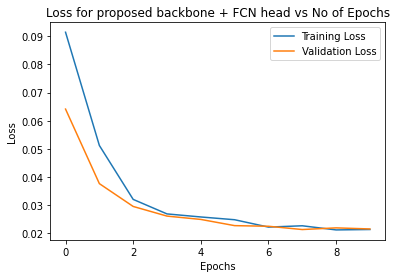

In [35]:
plot_loss_vs_epochs(epoch_train_loss, epoch_test_loss, 'Loss for proposed backbone + FCN head vs No of Epochs')

In [36]:
# Dice Coefficient
sum(dice_coeff_list)/len(dice_coeff_list)

tensor(0.7271, device='cuda:0')

In [37]:
dice_coeff_list

[tensor(0.1578, device='cuda:0'),
 tensor(0.7167, device='cuda:0'),
 tensor(0.7736, device='cuda:0'),
 tensor(0.7944, device='cuda:0'),
 tensor(0.7986, device='cuda:0'),
 tensor(0.8088, device='cuda:0'),
 tensor(0.8162, device='cuda:0'),
 tensor(0.8156, device='cuda:0'),
 tensor(0.7800, device='cuda:0'),
 tensor(0.8092, device='cuda:0')]

In [45]:
def get_output_masks(dataloader):
    '''
    Get some output images, see how good we are learning the masks
    '''
    for img, _, file_name in dataloader:
        img = img.to(device)
        predicted_mask = improved_resnet(img)
        predicted_mask = bilinear_interpolation(predicted_mask, img)
        for patch_idx in range(len(predicted_mask)):
            predicted_mask_patch = predicted_mask[patch_idx].cpu().detach().numpy()
            predicted_mask_patch = Image.fromarray((predicted_mask_patch.argmax(0) * 255).astype(np.uint8))
            
            predicted_mask_segmented, masks_count = label(np.array(predicted_mask_patch), connectivity=2, background=0, return_num=True)
            if masks_count != 0:
                scaling_factor = int(255/masks_count)
            else:
                scaling_factor = 0
            predicted_mask_segmented_grayscale = Image.fromarray((predicted_mask_segmented * scaling_factor).astype(np.uint8))
            
            predicted_mask_segmented_grayscale.save(f'{PREDICTED_MASKS_PATH}{file_name[patch_idx]}.tiff')

In [29]:
get_output_masks(test_dataloader)

# Produce masks using Kurt's data - Incomplete as of now

In [ ]:
def preprocess_image(path):
    stacks_list = os.listdir(path)
    print(stacks_list)
    big_stack = []
    for file_path in pathlib.Path(path).iterdir():
        print(f"Reading: {file_path}")
        stack = imageio.imread(file_path)
        np_stack = np.asarray(stack)
        patches = view_as_windows(np_stack, WINDOW_SHAPE, step=(64, 64))
        for row in range(patches.shape[0]):
            for col in range(patches.shape[1]):
                big_stack.append(patches[row][col])
    return big_stack

In [ ]:
image_stack = preprocess_image('/home/snamburi/Srinath/kurt_data')

In [ ]:
threshold = calculate_threshold(image_stack)

In [ ]:
def create_input_data(image_stack, threshold):
    for patch_idx in range(len(image_stack)):
        image = image_stack[patch_idx]
        if(image.mean() >= threshold):
            io.imsave(f"{ZEBRAFISH_IMAGES_PATH}/{patch_idx}.tiff", image)

In [ ]:
create_input_data(image_stack, threshold)

In [ ]:
def get_output_mask_one_image(img_path, filename):
    img = torch.tensor(imageio.imread(img_path).astype(np.float32))
    img = img.repeat(8, 3 ,1,1)
    print(img.shape)
    img = img.to(device)
    predicted_mask = improved_resnet(img)
    predicted_mask = bilinear_interpolation(predicted_mask, img)
    for patch_idx in range(len(predicted_mask)):
        predicted_mask_patch = predicted_mask[patch_idx].cpu().detach().numpy()
        predicted_mask_patch = Image.fromarray((predicted_mask_patch.argmax(0) * 255).astype(np.uint8))
        #for pixel in iter(predicted_mask_patch.getdata()):
           # print(pixel)
        predicted_mask_patch.save(f'{ZEBRAFISH_PREDICTED_MASKS_PATH}{filename}.tiff')
    

In [ ]:
get_output_mask_one_image(f'{ZEBRAFISH_IMAGES_PATH}/91.tiff', 91)

In [ ]:
zebrafish_dataloader = DataLoader(small_sample_size_testdata, batch_size=8, shuffle=True, num_workers=0)